In [14]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.optimize import minimize

### Generating price signal vector (LUCAS's Given Code)

In [15]:
pv = np.array([])
price = np.array([])
demand = np.array([])

with open('building_data.csv', encoding='utf8') as csvfile:
# with open('../../building_data.csv', encoding='utf8') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    next(csvreader,None)
    rowcount = 0
    for row in csvreader:
        pv = np.append(pv, 0.001*float(row[3])) # Converting Wh to kWh
        price = np.append(price, float(row[2])) # Cost per kWh
        val = row[5]
        if val in (None,""): #How to treat missing values
            val = 0
        else:
            val = float(val) # kWh
        demand = np.append(demand, val)
        rowcount+=1
        # if rowcount>100:
        #     break

pvsize = 5 #Assumption

netdemand = demand.copy()
for i in range(len(demand)):
    netdemand[i] = demand[i] - pvsize*pv[i]

# Data starts at 5 am on Jan 1
day = 45
netdemand_24 = netdemand[24*day-5:24*day+19]
price_24 = price[24*day-5:24*day+19]
pv_24 = pv[24*day-5:24*day+19]
demand_24 = demand[24*day-5:24*day+19]

# Calculate optimal load scheduling. 90% of load is fixed, 10% is controllable.
def optimise_24h(netdemand_24, price_24):
    currentcost = netdemand_24*price_24
    
    fixed_load = 0.9*netdemand_24
    controllable_load = sum(0.1*netdemand_24)
    # fixed_load = 0*netdemand_24
    # controllable_load = sum(netdemand_24)
    
    def objective(x):
        load = fixed_load + x
        cost = np.multiply(price_24,load)
        # Negative demand means zero cost, not negative cost
        # Adding L1 regularisation to penalise shifting of occupant demand
        lambd = 0.005
        return sum(np.maximum(cost,0)) + lambd*sum(abs(x-0.1*netdemand_24))

    def constraint_sumofx(x):
        return sum(x) - controllable_load
    
    def constraint_x_positive(x):
        return x 

    x0 = np.zeros(24)
    cons = [
        {'type':'eq', 'fun': constraint_sumofx},
        {'type':'ineq', 'fun':constraint_x_positive}
    ]
    sol = minimize(objective, x0, constraints=cons)
    #print(sol)
    return sol

sol = optimise_24h(netdemand_24,price_24)
x = sol['x']
#plt.plot(netdemand_24, color='r')
#plt.plot(x + 0.9*netdemand_24, color='b')
# plt.plot(x,color='b')
#plt.plot(demand_24,color='m')
#plt.plot(price_24*100, color='g')
#plt.plot(pv_24*pvsize,color='y')
#plt.show()

# Signal should be according to what the optimal shifted controllable load is (x)
signal = x / np.linalg.norm(x)
signal = signal.tolist()
signal = signal[12:] + signal[:12]
signal = np.array(signal)
#plt.show()

# Pre-Treatment Dataset 1 (BaselineHourlyData)
### Summed over all work groups, then averaged by num of days

In [16]:
total_energy_used = [0.0 for i in range(24)]
with open('BaselineHourlyData.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    curr_wg = ["WORKGROUP-01","WORKGROUP-02","WORKGROUP-03"]
    prev_hour_usage = 0.0
    for row in readCSV:
        if(row[0]=="index"):
            continue
        else:
            curr_hour = int(float(row[3]))
            pwr = float(row[6])
            if(row[4] in curr_wg):
                diff = pwr - prev_hour_usage
                if(diff < 0.0):
                    diff = 0.0
                total_energy_used[curr_hour] = total_energy_used[curr_hour] + diff
                prev_hour_usage = pwr
total_energy_used = total_energy_used[9:] + total_energy_used[:9]
avg_energy_used = np.array([p / 62.0 for p in total_energy_used])

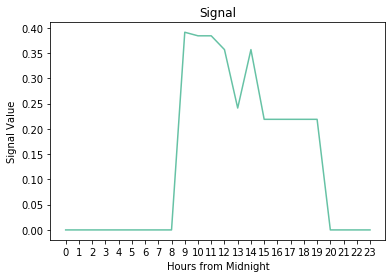

In [17]:
plt.plot(signal,'#66c2a5')
plt.xlabel("Hours from Midnight")
plt.xticks([i for i in range(0,24)])
plt.ylabel("Signal Value")
plt.title("Signal")
plt.show()

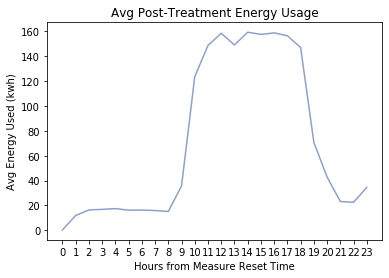

In [18]:
plt.plot(avg_energy_used,'#8da0cb')
plt.xlabel("Hours from Measure Reset Time")
plt.xticks([i for i in range(0,24)])
plt.ylabel("Avg Energy Used (kwh)")
plt.title("Avg Post-Treatment Energy Usage")
plt.show()

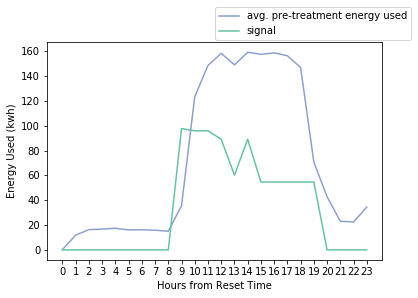

In [19]:
plt.plot(avg_energy_used,label="avg. pre-treatment energy used",color='#8da0cb')
plt.plot(250*signal,label='signal',color='#66c2a5')
plt.xlabel("Hours from Reset Time")
plt.ylabel("Energy Used (kwh)")
plt.xticks([i for i in range(0,24)])
plt.legend(loc=(0.5,1.01))

# Post Treatment Data
#### Using same subset as before
#### In our post-treatment data, we don't have all of 10/14

In [25]:
total_energy_used = [0.0 for i in range(24)]
with open('HourlyDataFinal.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    curr_wg = ["WORKGROUP-01","WORKGROUP-02","WORKGROUP-03"]
    prev_hour_usage = 0.0
    for row in readCSV:  
        if(row[2] == "Date"):
            continue
        else:
            curr_hour = int(float(row[4]))
            pwr = float(row[7])
            if(row[5] in curr_wg):
                diff = pwr - prev_hour_usage
                if(diff < 0.0):
                    diff = 0.0
                total_energy_used[curr_hour] = total_energy_used[curr_hour] + diff
                prev_hour_usage = pwr
total_energy_used = total_energy_used[10:] + total_energy_used[:10]
avg_energy_used_post = np.array([p / 77.0 for p in total_energy_used])

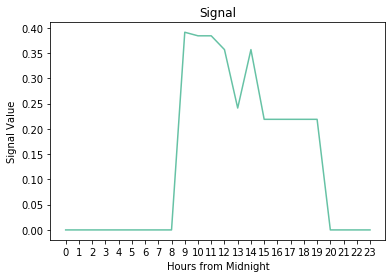

In [26]:
plt.plot(signal,label='Signal',color='#66c2a5')
plt.xlabel("Hours from Midnight")
plt.xticks([i for i in range(0,24)])
plt.ylabel("Signal Value")
plt.title("Signal")
plt.show()

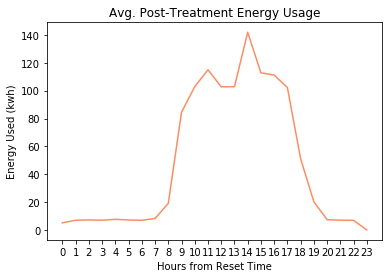

In [27]:
plt.plot(avg_energy_used_post,label="avg. post-treatment energy used",color='#fc8d62')
plt.xlabel("Hours from Reset Time")
plt.xticks([i for i in range(0,24)])
plt.ylabel("Energy Used (kwh)")
plt.title("Avg. Post-Treatment Energy Usage")
plt.show()

## Combining Signal and Post-Treatment Graph (*Scale factor tbd)

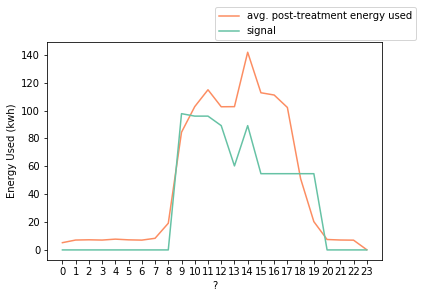

In [28]:
plt.plot(avg_energy_used_post,label="avg. post-treatment energy used",color='#fc8d62')
plt.plot(250*signal,label='signal',color='#66c2a5')
plt.xlabel("?")
plt.ylabel("Energy Used (kwh)")
plt.xticks([i for i in range(0,24)])
plt.legend(loc=(0.5,1.01))

# Power Analysis:
## Combining Pre, Post, and Signal
#### Once again for the aforementioned subset

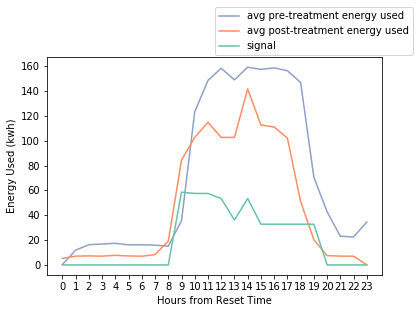

In [29]:
plt.plot(avg_energy_used,label="avg pre-treatment energy used",color='#8da0cb')
plt.plot(avg_energy_used_post,label="avg post-treatment energy used",color='#fc8d62')
plt.plot(150*signal,label='signal',color='#66c2a5')
plt.xlabel("Hours from Reset Time")
plt.ylabel("Energy Used (kwh)")
plt.xticks([i for i in range(0,24)])
plt.legend(loc=(0.5,1.01))